# Data Ingestion – Hierarchical Formats

In [1]:
from src.setup import *
%load_ext rpy2.ipython

In [2]:
%%capture --no-stdout err
%%R
library(tidyverse)

## JSON

### What JSON Looks Like

In [3]:
# A response to an HTTP request
response = requests.get('http://localhost:3001/users') 

# Show status code, content-type, and JSON body
print(response.status_code, response.headers['Content-Type'])
response.text

200 application/json; charset=utf-8


'{"1":{"name":"Guido van Rossum","password":"unladenswallow","details":{"profession":"ex-BDFL"}},"2":{"name":"Brendan Eich","password":"nontransitiveequality","details":{"profession":"Mozillan"}},"3":{"name":"Ken Thompson","password":"p/q2-q4!","details":{"profession":"Unix Creator"}}}'

In [4]:
pprint_json(response.text)

{
  "1": {
    "name": "Guido van Rossum",
    "password": "unladenswallow",
    "details": {
      "profession": "ex-BDFL"
    }
  },
  "2": {
    "name": "Brendan Eich",
    "password": "nontransitiveequality",
    "details": {
      "profession": "Mozillan"
    }
  },
  "3": {
    "name": "Ken Thompson",
    "password": "p/q2-q4!",
    "details": {
      "profession": "Unix Creator"
    }
  }
}


In [5]:
with open('data/3001.json', 'w') as fh:
    fh.write(response.text)

In [6]:
%%bash
jq . data/3001.json

{
  "1": {
    "name": "Guido van Rossum",
    "password": "unladenswallow",
    "details": {
      "profession": "ex-BDFL"
    }
  },
  "2": {
    "name": "Brendan Eich",
    "password": "nontransitiveequality",
    "details": {
      "profession": "Mozillan"
    }
  },
  "3": {
    "name": "Ken Thompson",
    "password": "p/q2-q4!",
    "details": {
      "profession": "Unix Creator"
    }
  }
}


In [7]:
%%bash
js="
const fs = require('fs');
let raw = fs.readFileSync('data/3001.json');
let users = JSON.parse(raw);
console.log(users);
"
echo $js | node

{
  '1': {
    name: 'Guido van Rossum',
    password: 'unladenswallow',
    details: { profession: 'ex-BDFL' }
  },
  '2': {
    name: 'Brendan Eich',
    password: 'nontransitiveequality',
    details: { profession: 'Mozillan' }
  },
  '3': {
    name: 'Ken Thompson',
    password: 'p/q2-q4!',
    details: { profession: 'Unix Creator' }
  }
}


In [8]:
with open('data/3001.json') as fh:
    # Could also call `json.load(fh)` to read file
    raw = fh.read()
    users = json.loads(raw)
users

{'1': {'name': 'Guido van Rossum',
  'password': 'unladenswallow',
  'details': {'profession': 'ex-BDFL'}},
 '2': {'name': 'Brendan Eich',
  'password': 'nontransitiveequality',
  'details': {'profession': 'Mozillan'}},
 '3': {'name': 'Ken Thompson',
  'password': 'p/q2-q4!',
  'details': {'profession': 'Unix Creator'}}}

In [9]:
%%R
library(rjson)
result <- fromJSON(file = "data/3001.json")
result[3]

$`3`
$`3`$name
[1] "Ken Thompson"

$`3`$password
[1] "p/q2-q4!"

$`3`$details
$`3`$details$profession
[1] "Unix Creator"





### NaN Handling and Data Types

In [10]:
# An interpreted float, an overflow, and a truncation
json_str = "[1e308, 1e309, 1.2345678901234567890]"
json.loads(json_str)

[1e+308, inf, 1.2345678901234567]

In [11]:
%%R -i json_str
options(digits = 22)
fromJSON(json_str)

[1] 1.000000000000000010979e+308                          Inf
[3]  1.234567890123456690432e+00


In [12]:
simplejson.loads(json_str, use_decimal=True)

[Decimal('1E+308'), Decimal('1E+309'), Decimal('1.2345678901234567890')]

In [13]:
specials = "[NaN, Infinity, -Infinity]"
vals = json.loads(specials)
vals

[nan, inf, -inf]

In [14]:
%%R -i vals
vals = c(NaN, Inf, -Inf)
print(vals)
print("R version of 'enhanced JSON':")
rjson_str = toJSON(vals)  # function from rjson library
print(rjson_str)

[1]  NaN  Inf -Inf
[1] "R version of 'enhanced JSON':"
[1] "[\"NaN\",\"Inf\",\"-Inf\"]"


In [15]:
%%R
print("Read back in 'enhanced JSON':")
fromJSON(rjson_str)

[1] "Read back in 'enhanced JSON':"
[1] "NaN"  "Inf"  "-Inf"


In [16]:
%%bash
js="JSON.parse('[NaN, Infinity, -Infinity]');"
echo $js | node | cat

undefined:1
[NaN, Infinity, -Infinity]
 ^

SyntaxError: Unexpected token N in JSON at position 1
    at JSON.parse (<anonymous>)
    at [stdin]:1:6
    at Script.runInThisContext (vm.js:132:18)
    at Object.runInThisContext (vm.js:309:38)
    at internal/process/execution.js:77:19
    at [stdin]-wrapper:6:22
    at evalScript (internal/process/execution.js:76:60)
    at internal/main/eval_stdin.js:29:5
    at Socket.<anonymous> (internal/process/execution.js:198:5)
    at Socket.emit (events.js:327:22)


In [17]:
json.loads("[NaN, Infinity, -Infinity]", parse_constant=lambda _: "INVALID")

['INVALID', 'INVALID', 'INVALID']

In [18]:
try:
    json.loads("[nan, +Inf, Foobar]", parse_constant=lambda _: "INVALID")
except Exception as err:
    print_err(err)

JSONDecodeError
Expecting value: line 1 column 2 (char 1)


In [19]:
%%bash
echo "[NaN, inf, -Infinity]" | jq .

[
  null,
  1.7976931348623157e+308,
  -1.7976931348623157e+308
]


### JSON Lines

In [20]:
%%bash
cat -n data/jsonlines.log | fmt -w55 | tr -d " "

1	{"ts":"2020-06-18T10:44:13",
"logged_in":{"username":"foo"},
"connection":{"addr":"1.2.3.4","port":5678}}
2	{"ts":"2020-06-18T10:44:15",
"registered":{"username":"bar","email":"bar@example.com"},
"connection":{"addr":"2.3.4.5","port":6789}}
3	{"ts":"2020-06-18T10:44:16",
"logged_out":{"username":"foo"},
"connection":{"addr":"1.2.3.4","port":5678}}
4	{"ts":"2020-06-18T10:47:22",
"registered":{"username":"baz","email":"baz@example.net"},
"connection":{"addr":"3.4.5.6","port":7890}}


In [21]:
%%bash
# Extract registrations
grep "registered" data/jsonlines.log |
    sed 's/^.*registered"://' |
    sed 's/}.*/}/'

{"username":"bar","email":"bar@example.com"}
{"username":"baz","email":"baz@example.net"}


In [22]:
%%bash
jq '.registered | select(.username != null)' data/jsonlines.log

{
  "username": "bar",
  "email": "bar@example.com"
}
{
  "username": "baz",
  "email": "baz@example.net"
}


In [23]:
with open('data/jsonlines.log') as log:
    for line in log:
        record = json.loads(line)
        if 'registered' in record:
            user = record['registered']
            if 'username' in user:
                print(user)

{'username': 'bar', 'email': 'bar@example.com'}
{'username': 'baz', 'email': 'baz@example.net'}


### GeoJSON

In [24]:
with open('data/gz_2010_us_050_00_20m.json', encoding='ISO-8859-1') as fh:
    counties = json.load(fh)

counties.keys()

dict_keys(['type', 'features'])

In [25]:
counties['type'], type(counties['features']), len(counties['features'])

('FeatureCollection', list, 3221)

In [26]:
counties['features'][999]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US19153',
  'STATE': '19',
  'COUNTY': '153',
  'NAME': 'Polk',
  'LSAD': 'County',
  'CENSUSAREA': 573.795},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-93.328614, 41.507824],
    [-93.328486, 41.49134],
    [-93.328407, 41.490921],
    [-93.41226, 41.505549],
    [-93.790612, 41.511916],
    [-93.814282, 41.600448],
    [-93.815527, 41.863419],
    [-93.698032, 41.86337],
    [-93.347933, 41.863104],
    [-93.348681, 41.600999],
    [-93.328614, 41.507824]]]}}

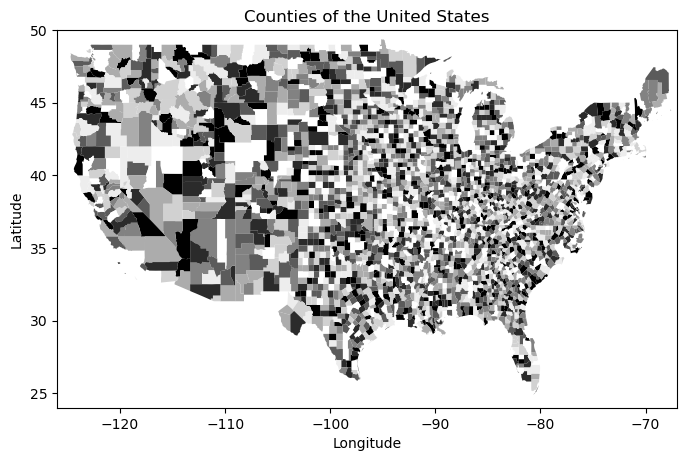

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
patches, colors, ncolor = [], [], 8

for n, county in enumerate(counties['features']):
    # Only use first polygon if multiple discontiguous regions
    poly = np.array(county['geometry']['coordinates'][0])
    poly = poly.reshape(-1, 2)
    polygon = Polygon(poly)
    patches.append(polygon)
    colors.append(n % ncolor)

p = PatchCollection(patches, cmap=cm.get_cmap('Greys', ncolor))
p.set_array(np.array(colors))
ax.add_collection(p)

ax.set_ylim(24, 50)
ax.set_ylabel("Latitude")
ax.set_xlim(-126, -67)
ax.set_xlabel("Longitude")
ax.set_title("Counties of the United States");
plt.savefig("img/(Ch02)Counties of the United States.png")

### Tidy Geography

In [28]:
fips = pd.read_csv('data/FIPS.tsv', sep='\t')
fips

,Name,Postal Code,FIPS
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
...,...,...,...
51,Guam,GU,66
52,Northern Mariana Islands,MP,69
53,Puerto Rico,PR,72
54,Virgin Islands,VI,78


In [29]:
fips_map = fips.set_index('FIPS').Name
fips_map

FIPS
1                      Alabama
2                       Alaska
4                      Arizona
5                     Arkansas
                ...           
66                        Guam
69    Northern Mariana Islands
72                 Puerto Rico
78              Virgin Islands
Name: Name, Length: 55, dtype: object

In [30]:
def extremes(coords):
    lat, lon = [], []
    # Expect a list of lists of lists
    for region in coords:
        for point in region:
            lat.append(point[1])
            lon.append(point[0])
    # We are assuming western hemisphere here
    north = max(lat)
    south = min(lat)
    east = max(lon)
    west = min(lon)
    return north, south, east, west

In [31]:
def county_summary(features):
    geo_id = []
    state, county_name, area = [], [], []
    north, south, east, west = [], [], [], []

    for county in features:
        props = county['properties']
        polys = county['geometry']['coordinates']
        geo_id.append(props['GEO_ID'])
        # District of Columbia not US state (default to None)
        state_name = fips_map.get(int(props['STATE']), None)
        state.append(state_name)
        county_name.append(props['NAME'])
        area.append(props['CENSUSAREA'] * 2.59)
        n, s, e, w = extremes(polys)
        north.append(n)
        south.append(s)
        east.append(e)
        west.append(w)

    df = pd.DataFrame({
            'geo_id': geo_id,
            'state': state,
            'county': county_name,
            'area': area,
            'northmost': north,
            'southmost': south,
            'eastmost': east,
            'westmost': west
        })
    return df.set_index('geo_id')

In [32]:
def test_counties(df):
    assert (df.northmost > df.southmost).all()
    assert (df.westmost < df.eastmost).all()
    assert (df.area > 0).all()

In [33]:
census_counties = county_summary(counties['features'])

# Sanity checks (if no assertion violated, we are happy)
test_counties(census_counties)
census_counties

,state,county,area,northmost,southmost,eastmost,westmost
geo_id,,,,,,,
0500000US01001,Alabama,Autauga,1539.58924,32.7074,32.3408,-86.4112,-86.9176
0500000US01009,Alabama,Blount,1669.96984,34.2593,33.7653,-86.3035,-86.9634
0500000US01017,Alabama,Chambers,1545.01529,33.1081,32.7285,-85.1234,-85.5932
0500000US01021,Alabama,Chilton,1794.49186,33.0719,32.6617,-86.375,-87.0192
...,...,...,...,...,...,...,...
0500000US51021,Virginia,Bland,926.50775,37.2935,36.9524,-80.8546,-81.4622
0500000US51027,Virginia,Buchanan,1302.15617,37.5378,37.0417,-81.7384,-82.3059
0500000US51037,Virginia,Charlotte,1230.95189,37.2488,36.6979,-78.4433,-78.9046
0500000US51041,Virginia,Chesterfield,1096.33923,37.5626,37.2227,-77.2442,-77.8551


### JSON Schema

In [34]:
response = requests.get('https://geojson.org/schema/GeoJSON.json')
geojson_schema = json.loads(response.text)

if msg := not_valid(counties, geojson_schema):
    print(msg)
else:
    print("Everything is Happy!")

Everything is Happy!


In [35]:
user_schema = json.loads("""
{
  "$schema": "http://json-schema.org/draft-07/schema#",
  "$id": "http://kdm.training/user-schema.json",
  "title": "User",
  "description": "A User of Our Computer System",
  "type" : "object",
  "required": ["name", "password"],
  "properties" : {
     "name" : {"type" : "string"},
     "password": {
         "description": "Use special characters and mixed case",
         "type": "string"},
     "lucky_numbers": {
         "description": "Up to 6 favorite numbers 1-100",
         "type": "array",
         "items": {
           "type": "number",
           "minimum": 1,
           "maximum": 100
         },
         "uniqueItems": true,
         "minItems": 0,
         "maxItems": 6
    }
  }
}
""")

In [36]:
david = json.loads("""
{
  "name": "David Mertz",
  "password": "badpassword",
  "details": {
    "profession": "Data Scientist",
    "employer": "KDM"
  },
  "lucky_numbers": [12, 42, 55, 87]
}
""")

if msg := not_valid(david, user_schema):
    print(msg)

In [37]:
barbara_feldon = json.loads("""
{
  "name": 99, 
  "password": "1ibydieZ!S@8"
}
""")

if msg := not_valid(barbara_feldon, user_schema):
    print(msg)

99 is not of type 'string'

Failed validating 'type' in schema['properties']['name']:
    {'type': 'string'}

On instance['name']:
    99


In [38]:
intruder = json.loads("""
{
  "password": "P4cC!^*8chWz8", 
  "profession": "Hacker"
}
""")

if msg := not_valid(intruder, user_schema):
    print(msg)

'name' is a required property

Failed validating 'required' in schema:
    {'$id': 'http://kdm.training/user-schema.json',
     '$schema': 'http://json-schema.org/draft-07/schema#',
     'description': 'A User of Our Computer System',
     'properties': {'lucky_numbers': {'description': 'Up to 6 favorite '
                                                     'numbers 1-100',
                                      'items': {'maximum': 100,
                                                'minimum': 1,
                                                'type': 'number'},
                                      'maxItems': 6,
                                      'minItems': 0,
                                      'type': 'array',
                                      'uniqueItems': True},
                    'name': {'type': 'string'},
                    'password': {'description': 'Use special characters '
                                                'and mixed case',
                    

In [39]:
the_count = json.loads("""
{
  "name": "Count von Count",
  "password": "fourbananas",
  "lucky_numbers": ["one", "two", "three"]
}
""")

if msg := not_valid(the_count, user_schema):
    print(msg, "\n--------------------")

'one' is not of type 'number'

Failed validating 'type' in schema['properties']['lucky_numbers']['items']:
    {'maximum': 100, 'minimum': 1, 'type': 'number'}

On instance['lucky_numbers'][0]:
    'one' 
--------------------


In [40]:
george = json.loads("""
{
  "name": "Georg Cantor",
  "password": "omega_aleph",
  "lucky_numbers": [1, 2, 3, 4, 5, 6, 7, 8]
}
""")

if msg := not_valid(george, user_schema):
    print(msg)

[1, 2, 3, 4, 5, 6, 7, 8] is too long

Failed validating 'maxItems' in schema['properties']['lucky_numbers']:
    {'description': 'Up to 6 favorite numbers 1-100',
     'items': {'maximum': 100, 'minimum': 1, 'type': 'number'},
     'maxItems': 6,
     'minItems': 0,
     'type': 'array',
     'uniqueItems': True}

On instance['lucky_numbers']:
    [1, 2, 3, 4, 5, 6, 7, 8]


In [41]:
revolution_9 = json.loads("""
{
  "name": "Yoko Ono",
  "password": "grapefruit",
  "lucky_numbers": [9, 9, 9]
}
""")

if msg := not_valid(revolution_9, user_schema):
    print(msg)

[9, 9, 9] has non-unique elements

Failed validating 'uniqueItems' in schema['properties']['lucky_numbers']:
    {'description': 'Up to 6 favorite numbers 1-100',
     'items': {'maximum': 100, 'minimum': 1, 'type': 'number'},
     'maxItems': 6,
     'minItems': 0,
     'type': 'array',
     'uniqueItems': True}

On instance['lucky_numbers']:
    [9, 9, 9]


## XML

### User Records

In [42]:
import xml.etree.ElementTree as ET
tree = ET.parse('data/users.xml')

# Let us first find the attributes and text of a profession
prof = tree.find('user').find('details').find('profession')
print("Body (title):", prof.text.strip())
print("Attributes:  ", prof.attrib)

Body (title): Data Scientist
Attributes:   {'employer': 'KDM', 'duration': '26', 'units': 'months'}


In [43]:
items = tree.find('user').find('lucky-numbers').findall('item')
lucky_numbers = [int(item.text) for item in items]
lucky_numbers

[12, 42, 55, 87]

### Keyhole Markup Language

In [44]:
ns = {'kml': "http://www.opengis.net/kml/2.2"}
document = ET.parse('data/gz_2010_us_050_00_20m.kml')

root = document.getroot()
kml_doc = root.find('kml:Document', ns)
folder = kml_doc.find('kml:Folder', ns)

# Make sure we have the same number of counties as with GeoJSON
placemarks = folder.findall('kml:Placemark', ns)
print("Count of placemarks:", len(placemarks))
# Show one Placemark element object
placemarks[0]

Count of placemarks: 3221


<Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x7f2fdc184d10>

In [45]:
# The name of the county is comparatively straightforward
print("County name:", placemarks[0].find('kml:name', ns).text)

# Other county info is only distinguished by attribute
sdata = (placemarks[0].find('kml:ExtendedData', ns)
                      .find('kml:SchemaData', ns)
                      .findall('kml:SimpleData', ns))

# We are going to want GEO_ID, STATE and CENSUSAREA
for record in sdata:
    print(record.attrib, record.text)

County name: Autauga
{'name': 'Name'} Autauga
{'name': 'GEO_ID'} 0500000US01001
{'name': 'STATE'} 01
{'name': 'COUNTY'} 001
{'name': 'LSAD'} County
{'name': 'CENSUSAREA'} 594.436000000000035


In [46]:
coords = (placemarks[0].find('kml:Polygon', ns)
                       .find('kml:outerBoundaryIs', ns)
                       .find('kml:LinearRing', ns)
                       .find('kml:coordinates', ns))
pprint(coords.text)

('-86.497916734108713,32.346347937379285,123.940341341309249 '
 '-86.719045580223096,32.404719907202413,124.507383406162262 '
 '-86.816062031841554,32.342711234558017,124.433184524998069 '
 '-86.891734835750142,32.50487314981855,125.151479452848434 '
 '-86.918751525796665,32.666059588245083,125.785741473548114 '
 '-86.714541775531544,32.66362459160964,125.451970156282187 '
 '-86.715371359148733,32.707584324141543,125.614226697944105 '
 '-86.414261392701192,32.709278995622782,125.144079957157373 '
 '-86.41231357529395,32.411845326016262,124.046804890967906 '
 '-86.497916734108713,32.346347937379285,123.940341341309249')


In [47]:
def kml_extremes(coordinates):
    "Pass in a KML coordinates ElementTree object"
    text_points = coordinates.text.split()
    points = [p.split(',') for p in text_points]
    points = [[float(p[0]), float(p[1])] for p in points]
    # We pass a list-of-list-of-lists here
    return extremes([points])

kml_extremes(coords)

(32.70927899562278, 32.34271123455802, -86.41231357529395, -86.91875152579667)

In [48]:
def kml_county_summary(placemarks, ns=ns):
    geo_id = []
    state, county_name, area = [], [], []
    north, south, east, west = [], [], [], []

    for placemark in placemarks:
        # Get county name here and below to assure consistency
        name = placemark.find('kml:name', ns).text
        
        # Other county info is distinguished by XML attribute
        sdata = (placemark.find('kml:ExtendedData', ns)
                          .find('kml:SchemaData', ns)
                          .findall('kml:SimpleData', ns))
        # We want Name, GEO_ID, STATE and CENSUSAREA
        for record in sdata:
            rectype = record.attrib['name']  # XML attrib
            if rectype == 'Name':  # String 'Name' (county)
                # If name is recorded differently, problem!
                assert record.text == name
                county_name.append(name)
            elif rectype == 'GEO_ID':
                geo_id.append(record.text)
            elif rectype == 'CENSUSAREA':
                # Convert to km^2 from mi^2
                area.append(float(record.text) * 2.59)
            elif rectype == 'STATE':
                # District of Columbia is not a US state
                state_name = fips_map.get(int(record.text), None)
                state.append(state_name)

        # We are going to "cheat" here a little bit.  
        # Sometimes a placemark has a top level <MultiGeometry>
        # with several Polygons; we will skip that calculation 
        try:
            coordinates = (placemark
                    .find('kml:Polygon', ns)
                    .find('kml:outerBoundaryIs', ns)
                    .find('kml:LinearRing', ns)
                    .find('kml:coordinates', ns))                
            n, s, e, w = kml_extremes(coordinates)
        except AttributeError:
            n, s, e, w = None, None, None, None
            
        north.append(n); south.append(s); 
        east.append(e); west.append(w)

    df = pd.DataFrame({
            'geo_id': geo_id, 'state': state, 
            'county': county_name, 'area': area,
            'northmost': north, 'southmost': south,
            'eastmost': east, 'westmost': west
        })
    return df.set_index('geo_id')

In [49]:
kml_counties = kml_county_summary(placemarks)
kml_counties

,state,county,area,northmost,southmost,eastmost,westmost
geo_id,,,,,,,
0500000US01001,Alabama,Autauga,1539.58924,32.709279,32.342711,-86.412314,-86.918752
0500000US01009,Alabama,Blount,1669.96984,34.261131,33.767154,-86.304677,-86.964531
0500000US01017,Alabama,Chambers,1545.01529,33.109960,32.730429,-85.124537,-85.594308
0500000US01021,Alabama,Chilton,1794.49186,33.073731,32.663625,-86.376119,-87.020318
...,...,...,...,...,...,...,...
0500000US51021,Virginia,Bland,926.50775,37.295189,36.954152,-80.855694,-81.463294
0500000US51027,Virginia,Buchanan,1302.15617,37.539502,37.043415,-81.739470,-82.306981
0500000US51037,Virginia,Charlotte,1230.95189,37.250505,36.699679,-78.444320,-78.905600
0500000US51041,Virginia,Chesterfield,1096.33923,37.564372,37.224467,-77.245139,-77.856138


## Configuration Files

### INI and Flat Custom Formats

In [50]:
import configparser
cfg = configparser.ConfigParser()
cfg.read('data/example.ini')

print("Sections:   ", cfg.sections())
print("Owner keys: ", [k for k in cfg['owner']])
print("Owner/name: ", cfg['owner']['name'])
print("Port #:     ", cfg['database'].getint('port'))

Sections:    ['owner', 'database']
Owner keys:  ['name', 'organization']
Owner/name:  John Doe
Port #:      143


### TOML

In [51]:
import toml
toml.load(open('data/example.toml'))

{'title': 'TOML Example',
 'owner': {'name': 'Tom Preston-Werner',
  'dob': datetime.datetime(1979, 5, 27, 7, 32, tzinfo=<toml.tz.TomlTz object at 0x7f2fdc171a30>)},
 'database': {'server': '192.168.1.1',
  'ports': [8001, 8001, 8002],
  'connection_max': 5000,
  'enabled': True},
 'servers': {'alpha': {'ip': '10.0.0.1', 'dc': 'eqdc10'},
  'beta': {'ip': '10.0.0.2', 'dc': 'eqdc10'}},
 'clients': {'data': [['gamma', 'delta'], [1, 2]],
  'hosts': ['alpha', 'omega']}}

In [52]:
with open('data/example-bad.toml') as fh:
    try:
        cfg = toml.load(fh)
    except Exception as err:
        print_err(err)

TomlDecodeError
invalid literal for int() with base 0: '2] []
hosts = [   "alpha"' (line 27 column 1 char 433)


In [53]:
!cat -n data/example-bad.toml | tail -8

    26	[clients]
    27	data = [ ["gamma", "delta"], [1, 2] []
    28	
    29	# Line breaks are OK when inside arrays
    30	hosts = [
    31	  "alpha",
    32	  "omega"
    33	]

In [54]:
%%R
library(RcppTOML)
parseTOML("data/example.toml")

List of 5
 $ clients :List of 2
  ..$ data :List of 2
  .. ..$ : chr [1:2] "gamma" "delta"
  .. ..$ : int [1:2] 1 2
  ..$ hosts: chr [1:2] "alpha" "omega"
 $ database:List of 4
  ..$ connection_max: int 5000
  ..$ enabled       : logi TRUE
  ..$ ports         : int [1:3] 8001 8001 8002
  ..$ server        : chr "192.168.1.1"
 $ owner   :List of 2
  ..$ dob : POSIXct[1:1], format: "1979-05-27 15:32:00"
  ..$ name: chr "Tom Preston-Werner"
 $ servers :List of 2
  ..$ alpha:List of 2
  .. ..$ dc: chr "eqdc10"
  .. ..$ ip: chr "10.0.0.1"
  ..$ beta :List of 2
  .. ..$ dc: chr "eqdc10"
  .. ..$ ip: chr "10.0.0.2"
 $ title   : chr "TOML Example"


### Yet Another Markup Language

In [55]:
import yaml
order = yaml.load(open('data/example.yaml'))
order

{'invoice': 34843,
 'date': datetime.date(2001, 1, 23),
 'bill-to': {'given': 'Chris',
  'family': 'Dumars',
  'address': {'lines': '458 Walkman Dr.\nSuite #292\n',
   'city': 'Royal Oak',
   'state': 'MI',
   'postal': 48046}},
 'ship-to': {'given': 'Chris',
  'family': 'Dumars',
  'address': {'lines': '458 Walkman Dr.\nSuite #292\n',
   'city': 'Royal Oak',
   'state': 'MI',
   'postal': 48046}},
 'product': [{'sku': 'BL394D',
   'quantity': 4,
   'description': 'Basketball',
   'price': 450.0},
  {'sku': 'BL4438H',
   'quantity': 1,
   'description': 'Super Hoop',
   'price': 2392.0}],
 'tax': 251.42,
 'total': 4443.52,
 'comments': 'Late afternoon is best. Backup contact is Nancy Billsmer @ 338-4338.'}

In [56]:
# Is nested dict same object under different keys?
order['ship-to'] is order['bill-to']

True

In [57]:
with open('data/multidoc.yaml') as stream:
    docs = yaml.load_all(stream)
    print(docs, '\n')
    for doc in docs:
        print(doc)

<generator object load_all at 0x7f2fcf760820> 

{'name': 'David', 'age': 55}
{'name': 'Mei', 'age': 50}
{'name': 'Juana', 'age': 47}
{'name': 'Adebayo', 'age': 58}


In [58]:
try:
    yaml.load(open('data/example-bad.yaml'))
except Exception as err:
    print_err(err)

ScannerError
mapping values are not allowed here   in "data/example-bad.yaml", line
17, column 31


In [59]:
%%bash
cat -n data/example-bad.yaml | sed '15,19p;d' 

    15	    - sku         : BL394D
    16	      quantity    : 4
    17	      description : Basketball: ERROR
    18	      price       : 450.00
    19	    - sku         : BL4438H


In [60]:
try:
    for doc in yaml.load_all(open('data/multidoc-bad.yaml')):
        print(doc)
except Exception as err:
    print_err(err)

{'name': 'David', 'age': 55}
{'name': 'Mei', 'age': 50}
ScannerError
mapping values are not allowed here   in "data/multidoc-bad.yaml",
line 10, column 12


## NoSQL Databases

In [61]:
# Assume that MongoDB is running on local system
from pymongo import MongoClient
client = MongoClient('mongodb://localhost:27017')

In [62]:
# What databases exist on the local server?
client.database_names()

['admin', 'business', 'config', 'local']

In [63]:
db_biz = client.business
print("Restaurants:", db_biz.info.count())
for biz in db_biz.info.find(limit=3):
    pprint(biz)

Restaurants: 50
{'_id': ObjectId('5f30928db504836031a2c2a1'),
 'cuisine': 'Mexican',
 'name': 'Kitchen Tasty Inc.',
 'phone': '+1 524 555 9265'}
{'_id': ObjectId('5f30928db504836031a2c2a2'),
 'cuisine': 'Sandwich',
 'name': 'Sweet Salty Take-Out',
 'phone': '+1 408 555 6924'}
{'_id': ObjectId('5f30928db504836031a2c2a3'),
 'cuisine': 'Vegetarian',
 'name': 'City Kitchen Inc.',
 'phone': '+1 528 555 8923'}


In [64]:
print("Reviews:", db_biz.reviews.count())
for review in db_biz.reviews.find(limit=3):
    pprint(review)

Reviews: 5000
{'_id': ObjectId('5f30928db504836031a2c2d3'),
 'name': 'Tasty Sweet Inc.',
 'price': 'cheap',
 'rating': 1}
{'_id': ObjectId('5f30928db504836031a2c2d4'),
 'name': 'Big Big Restaurant',
 'price': 'cheap',
 'rating': 6}
{'_id': ObjectId('5f30928db504836031a2c2d5'),
 'name': 'Goat Big Take-Out',
 'price': 'reasonable',
 'rating': 8}


In [65]:
query = {'price': 'cheap', 'name': 'City Kitchen Inc.'}
for review in db_biz.reviews.find(query, limit=4):
    pprint(review)

{'_id': ObjectId('5f30928db504836031a2c2ea'),
 'name': 'City Kitchen Inc.',
 'price': 'cheap',
 'rating': 3}
{'_id': ObjectId('5f30928db504836031a2c435'),
 'name': 'City Kitchen Inc.',
 'price': 'cheap',
 'rating': 7}
{'_id': ObjectId('5f30928db504836031a2c553'),
 'name': 'City Kitchen Inc.',
 'price': 'cheap',
 'rating': 3}
{'_id': ObjectId('5f30928db504836031a2c5d6'),
 'name': 'City Kitchen Inc.',
 'price': 'cheap',
 'rating': 1}


#### Missing Fields

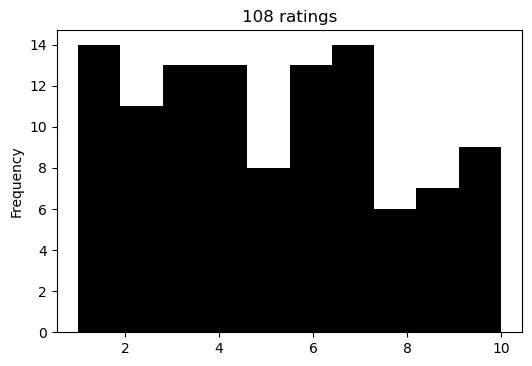

In [66]:
ratings = []
query = {'name': 'City Kitchen Inc.'}
for review in db_biz.reviews.find(query):
    try:
        ratings.append(review['rating'])
    except KeyError:
        pass

n = len(ratings)
pd.Series(ratings).plot(kind="hist", title=f"{n} ratings")
plt.savefig(f"img/(Ch02){n} ratings.png")

In [67]:
db_biz.reviews.find({'name': 'City Kitchen Inc.'}).count()

110

In [68]:
list(db_biz.reviews.find({'name': 'City Kitchen Inc.', 'rating': None}))

[{'_id': ObjectId('5f30928db504836031a2c3fa'),
  'name': 'City Kitchen Inc.',
  'price': 'expensive'},
 {'_id': ObjectId('5f30928db504836031a2c6b6'),
  'name': 'City Kitchen Inc.',
  'price': 'reasonable'}]

#### Denormalization and Its Discontents

In [69]:
def has_best_review(name, db=db_biz):
    "Return phone if restaurant has at least one 10 rating"
    query = {'name': name, 'rating': 10}
    review = None
    
    # Fast path has phone in local results
    for review in db.reviews.find(query):
        phone = review.get('phone')
        if phone:
            return f"Call {name} at {phone}! (FAST query)"

    # If there were no ratings of 10, we don't like it!
    if not review:
        return f"Do not bother with {name}!"

    # MUCH SLOWER path is second query
    info = db.info.find_one({'name': name})
    return f"Call {name} at {info['phone']}! (SLOW query)"

In [70]:
has_best_review('Salty Big Take-Out')

'Call Salty Big Take-Out at +1 354 555 8317! (FAST query)'

In [71]:
has_best_review('City Kitchen Inc.')

'Call City Kitchen Inc. at +1 528 555 8923! (SLOW query)'

In [72]:
has_best_review('Out of Business')

'Do not bother with Out of Business!'

In [73]:
query = {'name': 'Salty Big Take-Out', 
         'rating': 10, 'phone':{"$ne":None}}

db_biz.reviews.find_one(query)

{'_id': ObjectId('5f30928db504836031a2c7c9'),
 'name': 'Salty Big Take-Out',
 'price': 'reasonable',
 'rating': 10,
 'phone': '+1 354 555 8317'}

In [74]:
db_biz.info.find_one({'name': 'Salty Big Take-Out'})

{'_id': ObjectId('5f30928db504836031a2c2aa'),
 'name': 'Salty Big Take-Out',
 'cuisine': 'Mexican',
 'phone': '+1 967 555 5487'}

### Key/Value Stores

In [75]:
biz = dbm.open('data/keyval.db')
seed(6)
# Keys are bytes; could convert to strings if desired
sample(list(biz.keys()), 10)

[b'Big Sweet Take-Out::info::phone',
 b'Big Sweet Inc.::ratings',
 b'Goat Sweet Inc.::info::phone',
 b'Fish City Restaurant//ratings',
 b'Delight Goat Inc.::ratings',
 b'DESCRIPTION',
 b'Salty Delight Take-Out::ratings',
 b'Sweet Tasty Restaurant::info::phone',
 b'Delight Salty Restaurant::info::phone',
 b'Tasty Fish Inc.::info::cuisine']

In [76]:
name = b"Tasty Fish Inc."
print("Overview:", biz[b"DESCRIPTION"])
print("Cuisine: ", biz[name + b"::info::cuisine"] )
print("Ratings: ", biz[name + b"::ratings"][:30], "...")

Overview: b'Restaurant information'
Cuisine:  b'Mexican'
Ratings:  b'2;1;1;10;5;7;1;4;8;10;7;7;6;8;' ...


In [77]:
for key, val in biz.items():
    if key.startswith(b'Tasty Fish Inc.::'):
        print(key.decode(), '\t', val[:30].decode())

Tasty Fish Inc.::ratings 	 2;1;1;10;5;7;1;4;8;10;7;7;6;8;
Tasty Fish Inc.::info::phone 	 +1 935 555 8029
Tasty Fish Inc.::info::cuisine 	 Mexican


In [78]:
for key, val in biz.items():
    if key.startswith(b'Fish City Restaurant'):
        print(key, val[:30])

b'Fish City Restaurant::ratings' b'6;10;4;3;10;5;1;4;7;8;5;2;1;5;'
b'Fish City Restaurant//ratings' b'9'
b'Fish City Restaurant::info::phone' b'+1 851 555 1082'
b'Fish City Restaurant::info::cuisine' b'American'


## Exercises

### Create a Relational Model

In [79]:
dbm.whichdb('data/keyval.db')

'dbm.dumb'